## Amazon Review Data : Data Exploration

### Setup spark

In [1]:
# Import libraries
import os, pickle, glob
import pandas as pd
import numpy as np
import seaborn as sns
#import nltk
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import confusion_matrix, roc_curve, auc

#from nltk.corpus import wordnet, stopwords
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

from pyspark.sql import SparkSession, SQLContext, DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.ml.stat import Summarizer
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, split, lower, explode

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Word2Vec,HashingTF, Tokenizer, StringIndexer, OneHotEncoder, PCA, VectorAssembler,StopWordsRemover
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from nltk.corpus import wordnet

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Matplotlib created a temporary cache directory at /tmp/matplotlib-tjbvti3z because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "200g") \
	.config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 64) \
	.appName("Amazon Reviews") \
	.getOrCreate()

In [3]:
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Code to check data size

In [4]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = "../clin6/amazon_data"
folder_size_bytes = get_folder_size(folder_path)
folder_size_kb = folder_size_bytes / 1024
folder_size_mb = folder_size_kb / 1024
folder_size_gb = folder_size_mb / 1024

print("Folder size:", folder_size_bytes, "bytes")
print("Folder size:", folder_size_kb, "KB")
print("Folder size:", folder_size_mb, "MB")
print("Folder size:", folder_size_gb, "GB")

Folder size: 54412794661 bytes
Folder size: 53137494.78613281 KB
Folder size: 51892.084752082825 MB
Folder size: 50.67586401570588 GB


## Read Data

### Get files

In [5]:
#######################################################################################
###################### change path to: "../clin6/amazon_data" #########################
#######################################################################################
# path = "../clin6/amazon_data"
path = "amazon_data"

In [6]:
def read(path):
    """
    Method that loads data file as df
    Takes in 1 parameter: path
    """
    return sc.read.csv(path, sep = "\t", header = True, inferSchema = True)

def get_path(file):
    """
    Method to create path
    Takes in 1 parameter: file name
    """
    return "amazon_data/%s" % file

In [7]:
dir = os.listdir(path)
files = [f for f in dir if os.path.isfile(os.path.join(path, f))]

# Data Preprocessing
* Finish major preprocessing, this includes scaling and/or transforming your data, imputing your data, encoding your data, feature expansion, Feature expansion (example is taking features and generating new features by transforming via polynomial, log multiplication of features).

In [8]:
product_category_column = 'product_category'
review_body_column = 'review_body'
review_date_column = 'review_date'
title_column = 'product_title'
category_column = 'product_category'
product_parent_column = 'product_parent'
review_body_column = 'review_body'
verified_purchase_column = 'verified_purchase'

product_category_col = F.col(product_category_column)
review_body_col = F.col(review_body_column)
review_date_col = F.col(review_date_column)
title_col = F.col(title_column)
category_col = F.col(category_column)
product_parent_col = F.col(product_parent_column)
review_body_col = F.col(review_body_column)
verified_purchase_col = F.col(verified_purchase_column)

## Load Data & Take care of missing categories

In [9]:
def get_imputed_df(files, category = True):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    categories = {}
    for i in range(n):
        data = read(get_path(files[i]))
        
        # Fill in null categories
        if category:
            cat = files[i][18:-10]
            categories[cat] = i
            data = data.withColumn(product_category_column,
                                   product_category_col).fillna(cat)
        
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df, categories

## Get df & Remove Columns

In [10]:
df, categories = get_imputed_df(files)
df = df.drop('marketplace', 'vine')#.cache()

In [11]:
sqlContext.registerDataFrameAsTable(df, "df")

In [12]:
columns = df.columns
num_cols = len(columns)

## Filter out rows with missing body and date and verified purchase

In [13]:
df = df.filter(review_body_col.isNotNull() & review_date_col.isNotNull())
df = df.filter(verified_purchase_col == True)

In [14]:
df.show(1)

+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|         review_body|review_date|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
|   36075342|RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|As it was used,|As it was used, t...| 2015-08-31|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+
only showing to

In [15]:
# Select the review_date column
review_date_col = F.col('review_date')

# Find the minimum and maximum dates
min_max_dates = df.agg(F.min(review_date_col).alias('min_date'), 
                       F.max(review_date_col).alias('max_date'))

min_max_dates.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|1995-11-09|2015-08-31|
+----------+----------+



## Filter out old data

In [16]:
# Data before 2010 is more irrelevent to forcaste future trends. 
df = df.filter(F.year(review_date_col) >= 2010)
df.show(3)

+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----------+
|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|     review_headline|         review_body|review_date|
+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----------+
|   36075342| RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|     As it was used,|As it was used, t...| 2015-08-31|
|   42462164|R3NORADVJO6IE6|B000C7S0TO|     907684644|Spectra Premium C...|      Automotive|          5|            0|          0|                Y|          Five Stars|Put it in fine, n..

## Check other missing values

In [17]:
df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = false)
 |-- product_id: string (nullable = false)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = false)
 |-- product_category: string (nullable = false)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- verified_purchase: string (nullable = false)
 |-- review_headline: string (nullable = false)
 |-- review_body: string (nullable = false)
 |-- review_date: date (nullable = true)



In [18]:
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 0 missing values
'star_rating' column has 0 missing values
'helpful_votes' column has 0 missing values
'total_votes' column has 0 missing values
'verified_purchase' column has 0 missing values
'review_headline' column has 0 missing values
'review_body' column has 0 missing values
'review_date' column has 0 missing values


* No more missing values

## Extract month and year

In [19]:
month_column = 'month'
year_column = 'year'

In [20]:
df = df.withColumn(month_column, F.month(review_date_col)).withColumn(year_column, F.year(review_date_col))
df.show(1)

+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+-----+----+
|customer_id|    review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|verified_purchase|review_headline|         review_body|review_date|month|year|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+--------------------+-----------+-----+----+
|   36075342|RAB23OVFNCXZQ|B00LPRXQ4Y|     339193102|17" 2003-2006 For...|      Automotive|          1|            0|          0|                Y|As it was used,|As it was used, t...| 2015-08-31|    8|2015|
+-----------+-------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+-----------------+---------------+-----

## Add Sub-category Column

In [21]:
subcategory_mapping = {
    'Major_Appliances': 'Home Essentials',
    'Kitchen': 'Home Essentials',
    'Home_Improvement': 'Home Essentials',
    'Tools': 'Home Essentials',
    'Home': 'Home Essentials',
    'Furniture': 'Home Essentials',
    'Office_Products':'Home Essentials',
    
    'Outdoors': 'Outdoor Living',
    'Home_Entertainment': 'Outdoor Living',
    'Lawn_and_Garden': 'Outdoor Living',
    
    'Video': 'Media',
    'Video_DVD': 'Media',
    'Music': 'Media',
    'Books': 'Media',
    'Video_Games': 'Media',
    'Software': 'Media',
    
    'Digital_Music_Purchase': 'Digital Media',
    'Digital_Video_Download': 'Digital Media',
    'Digital_Ebook_Purchase': 'Digital Media',
    'Digital_Video_Games': 'Digital Media',
    'Digital_Software':'Digital Media',

    'Mobile_Apps': 'Electronics',
    'Wireless': 'Electronics',
    'PC': 'Electronics',
    'Electronics': 'Electronics',
    'Mobile_Electronics': 'Electronics',
    'Camera': 'Electronics',
    
    'Shoes': 'Apparel and Accessories',
    'Watches': 'Apparel and Accessories',
    'Luggage': 'Apparel and Accessories',
    'Apparel': 'Apparel and Accessories',
    
    'Health_Personal_Care': 'Personal Care',
    'Beauty': 'Personal Care',
    'Personal_Care_Appliances': 'Personal Care',
    
    'Sports': 'Entertainment and Leisure',
    'Musical_Instruments': 'Entertainment and Leisure',
    'Toys': 'Entertainment and Leisure',
    'Gift_Card': 'Entertainment and Leisure',
    
    'Baby': 'Family and Living',
    'Automotive': 'Family and Living',
    'Grocery': 'Family and Living',
    'Pet_Products': 'Family and Living',
}

In [22]:
'''
from pyspark.sql.functions import year, month, col, date_format,count

# Assuming your DataFrame is called 'df'

# Filter the DataFrame for rows where the month is December and the year is 2014
df_dec_2014 = df.filter((year(df['review_date']) == 2014) & (month(df['review_date']) == 12))

# Count the number of rows
count_dec_2014 = df_dec_2014.count()

print("Count of review_date in December 2014:", count_dec_2014)
'''

'\nfrom pyspark.sql.functions import year, month, col, date_format,count\n\n# Assuming your DataFrame is called \'df\'\n\n# Filter the DataFrame for rows where the month is December and the year is 2014\ndf_dec_2014 = df.filter((year(df[\'review_date\']) == 2014) & (month(df[\'review_date\']) == 12))\n\n# Count the number of rows\ncount_dec_2014 = df_dec_2014.count()\n\nprint("Count of review_date in December 2014:", count_dec_2014)\n'

## Encode Categorical Columns

### Match category to numbers

In [23]:
category_num_col = 'product_category_num'

In [24]:
def translate(dic): 
    return F.udf(lambda x: dic.get(x), StringType()) 

df = df.withColumn('product_category', translate(categories)(category_col))

## Dataset Splitting
* Use last year as test and the rest as train

In [25]:
train = df.filter((F.year(review_date_col) >= 2010) & (F.year(review_date_col) < 2015))
test = df.filter(F.year(review_date_col) == 2015)

print(train.count())
print(test.count())

56637783
27498612


## Count Product Reviews Per Day
* Group by unique product identifier and day to get reviews per day for each product

In [26]:
grouped_df = df.groupby(review_date_col, product_parent_col).count()

In [27]:
df.count()

84136395

# Model 2
## Define method to identify sentiment

In [28]:
def analyze_sentiment(text):
    positive_keywords = ["great", "awesome", "good", "excellent", "fantastic", "amazing", "love", "superb", 
    "wonderful", "brilliant", "perfect", "outstanding", "pleased", "happy", "impressed", 
    "satisfied", "excited", "delighted", "recommend", "best", "nice", "beautiful", 
    "wowed", "thrilled", "top-notch", "stellar", "remarkable", "joyful", "loved", 
    "positive", "fabulous", "glad", "incredible", "perfectly", "fun", "fantastically", 
    "terrific", "splendid", "marvelous", "exceptional", "vibrant", "exhilarating", 
    "extraordinary", "adorable", "masterpiece", "flawless", "charming", "impressive", 
    "enjoyable", "fascinating", "adoring", "treasure", "magic", "ideal", "genius", 
    "rocking", "sweet", "genuine", "bravo", "heavenly", "spectacular", "super", 
    "grateful", "praise", "awesome", "thankful", "golden", "delicious", "bold", 
    "champion", "remarkable", "strong", "success", "winning", "victory", "pride", 
    "celebrate", "cool", "treasure", "courage", "affection", "warm", "sunny", 
    "blessed", "innovative", "effective", "improve", "remarkable", "breakthrough",
    ":)", ":D", ";)", "<3", ":-)",
    "ecstatic", "fortunate", "stunning", "thriving", "admirable", "jubilant", 
    "splendiferous", "overjoyed", "awesome sauce", "heartwarming", "glowing", 
    "breathtaking", "radiant", "refreshing", "cheerful", "kind", "gentle", 
    "uplifting", "inspiring", "upbeat", "uplifting", "magical", "sensational", 
    "hopeful", "insightful", "benevolent", "jovial", "graceful", "luminous", 
    "rewarding", "funny", "euphoric", "blissful", "serene", "spiritual", 
    "thriving", "dynamic", "delightful", "jolly", "fab", "brill", "gleeful", 
    "thanksgiving", "enchanting", "pleasurable", "vivid", "masterful", 
    "splendorous", "affirmative", "genial", "heroic", "angelic", "bright"]    
    negative_keywords = ["disappointed", "not worth", "bad", "terrible", "poor", "horrible", "awful", 
    "disappointing", "waste", "worse", "dissatisfied", "painful", "sad", "unhappy", 
    "avoid", "problem", "difficult", "fail", "annoyed", "negative", "lacking", 
    "unfortunate", "concerned", "regret", "hate", "dislike", "stupid", "boring", 
    "lousy", "misleading", "inferior", "disgusting", "slow", "messy", "ugly", 
    "disastrous", "useless", "broken", "weak", "horrendous", "unacceptable", 
    "appalling", "insulting", "gross", "irritating", "unsatisfactory", "shameful", 
    "problematic", "trash", "flawed", "disturbing", "worthless", "confusing", 
    "unreliable", "displeased", "discomfort", "disheartened", "lamentable", 
    "nonsense", "horrific", "despicable", "depressing", "sick", "worst", "mess", 
    "complicated", "incompetent", "crappy", "upset", "miserable", "annoying", 
    "awkward", "misery", "suffering", "terribly", "unpleasant", "ridiculous", 
    "difficulties", "dreadful", "distress", "ruin", "disbelief", "confusion", 
    "sour", "scandal", "cursed", "heartbreaking", "horror", "injustice", "nightmare",
    ":(", ":-(", ":'(", ">:(", ">:|",
    "fiasco", "agony", "atrocity", "heartbreak", "diabolical", "sorrowful", 
    "unbearable", "ghastly", "repulsive", "woeful", "inexcusable", "displeasure", 
    "gut-wrenching", "shocking", "discomforting", "dreaded", "unlucky", "pathetic", 
    "humiliating", "horrifying", "undesirable", "unenviable", "grotesque", "tense", 
    "dire", "ugliness", "troublesome", "menacing", "depressing", "discomfiting", 
    "uninviting", "tragic", "ominous", "unpleasantness", "disastrous", "grievous", 
    "distressing", "lament", "pitiful", "deplorable", "pitiable", "unfavorable", 
    "woe", "gloomy", "dark", "nervous", "alarm", "grief", "heartache", "dreary", 
    "doom", "calamity", "melancholy", "bleak", "heavy-hearted", "harmful", 
    "soul-destroying", "heart-wrenching"]    
 
    # Convert text to lowercase
    text_lower = text.lower()
    
    # Check for positive sentiment
    for keyword in positive_keywords:
        if keyword in text_lower:
            return 1
    # Check for negative sentiment
    for keyword in negative_keywords:
        if keyword in text_lower:
            return 0
    # Default to positive sentiment if no keywords match
    return 1
df = df.filter(df["review_headline"].isNotNull())

# Register the function as a UDF (User Defined Function)
analyze_sentiment_udf = udf(analyze_sentiment, IntegerType())
# Apply the sentiment analysis UDF to your dataframe
df = df.withColumn("headline_sentiment", analyze_sentiment_udf(df["review_headline"]))

## Logistic regression
### Get target column

In [29]:
# Create binary target variable for star ratings
df = df.withColumn("high_rating", F.when(col("star_rating") >= 3, 1).otherwise(0))
# Define categorical columns and numerical columns

### Define columns to use in prediction

In [30]:
categorical_cols = ['product_category']
numerical_cols = ['helpful_votes', 'total_votes','headline_sentiment']

### Model preprocessing

In [31]:
# changes words to numbers 
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in categorical_cols]
# merge features 
assembler_inputs = [col+"_vec" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

### Modeling

In [32]:
# logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='high_rating')

# connecting pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Split data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
# Train the model
model = pipeline.fit(train_df)
# Make predictions
predictions = model.transform(test_df)

### Evaluation

In [33]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='high_rating')
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)
# Show classification report
predictions.select("high_rating", "prediction", "probability").show()

Accuracy: 0.7229236370695588
+-----------+----------+--------------------+
|high_rating|prediction|         probability|
+-----------+----------+--------------------+
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09257316761601...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          0|       0.0|[0.62688962584683...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          0|       1.0|[0.13486376160345...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|          0|       1.0|[0.09638729484049...|
|          1|       1.0|[0.09638729484049...|
|    

### Training AUC

In [34]:
# Make predictions on training data
train_predictions = model.transform(train_df)

# Evaluate the model on training data
train_auc = evaluator.evaluate(train_predictions)
print("Training AUC:", train_auc)

Training AUC: 0.7229997024635288


### Prediction counts

In [35]:
# Show classification report for testing data
predictions.groupBy("high_rating", "prediction").count().show()

+-----------+----------+--------+
|high_rating|prediction|   count|
+-----------+----------+--------+
|          1|       0.0|  192298|
|          0|       0.0|  440300|
|          1|       1.0|14458499|
|          0|       1.0| 1737219|
+-----------+----------+--------+



### Confusion Matrix
#### Get Confusion Matrix

In [36]:
# Show confusion matrix for training data
train_predictions.groupBy("high_rating", "prediction").count().show()

# Collect confusion matrix data
def extract_confusion_matrix_data(predictions):
    results = predictions.select(['high_rating', 'prediction']).collect()
    y_true = [row['high_rating'] for row in results]
    y_pred = [row['prediction'] for row in results]
    return y_true, y_pred

y_true_train, y_pred_train = extract_confusion_matrix_data(train_predictions)
y_true_test, y_pred_test = extract_confusion_matrix_data(predictions)

+-----------+----------+--------+
|high_rating|prediction|   count|
+-----------+----------+--------+
|          1|       0.0|  769210|
|          0|       0.0| 1762088|
|          1|       1.0|57833683|
|          0|       1.0| 6943098|
+-----------+----------+--------+



#### Plot Confusion Matrix

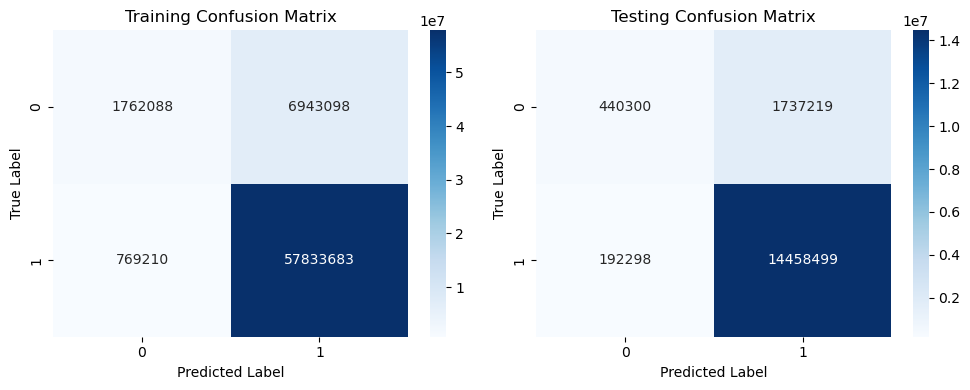

In [37]:
# Compute confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix for training data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Testing Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

## ROC Analysis
#### Get ROC data

In [38]:
# Collect ROC data
def extract_roc_data(predictions):
    results = predictions.select(['high_rating', 'probability']).collect()
    y_true = [row['high_rating'] for row in results]
    y_score = [row['probability'][1] for row in results]  # probability of class 1
    return y_true, y_score

# Extracting ROC data
y_true_train, y_score_train = extract_roc_data(train_predictions)
y_true_test, y_score_test = extract_roc_data(predictions)

# Compute ROC curve and ROC area for each class
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_score_train)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_true_test, y_score_test)
roc_auc_test = auc(fpr_test, tpr_test)

#### Plot ROC Curve

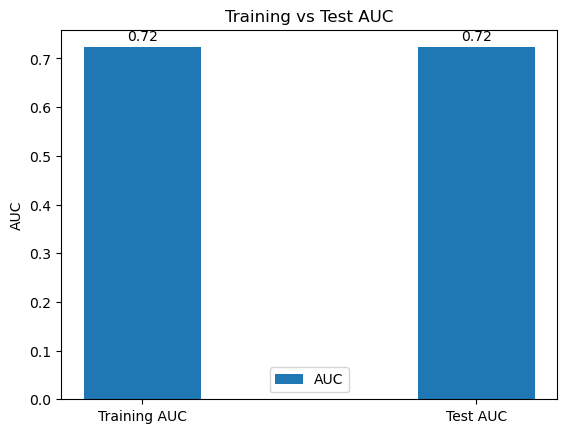

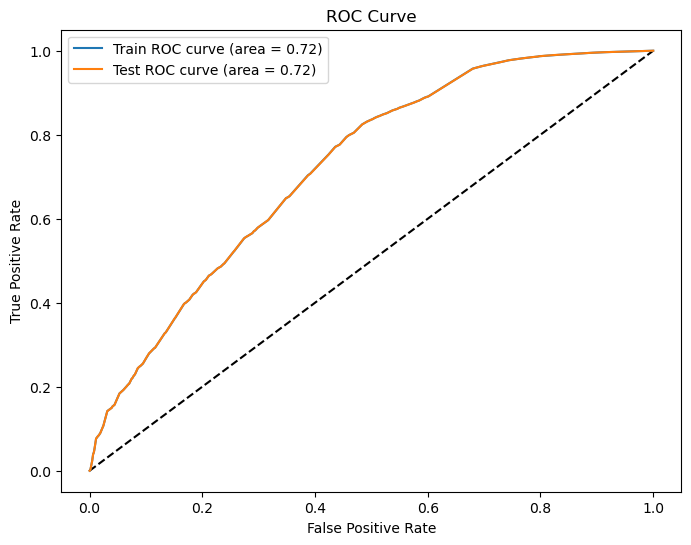

In [39]:
# Plot training and testing AUC
labels = ['Training AUC', 'Test AUC']
auc_values = [roc_auc_train, roc_auc_test]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots()
rects = ax.bar(x, auc_values, width, label='AUC')

ax.set_ylabel('AUC')
ax.set_title('Training vs Test AUC')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach labels to bars
def attach_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

attach_labels(rects)

plt.show()

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Answer the questions
* Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?

# Conclusion section
* What is the conclusion of your 2nd model? What can be done to possibly improve it?

# Visualizations Before ARIMA Model
## Get training data

In [75]:
train_df = train.select(review_date_col, product_category_col)\
                .withColumn("review_date", F.date_format(review_date_col, "yyyy-MM"))\
                .na.drop()

train_df.show(10)

+-----------+----------------+
|review_date|product_category|
+-----------+----------------+
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
|    2014-12|      Automotive|
+-----------+----------------+
only showing top 10 rows



## Get distinct categories

In [76]:
distinct_product_category_num = train_df.select("product_category").distinct()
distinct_product_category_num.count()

42

## Group by `year` and `month` then count

In [77]:
train_df = train_df.withColumn("year", F.year("review_date"))\
                   .withColumn("month", F.month("review_date"))

## Map to subcategories

In [78]:
broadcast_mapping = sc.sparkContext.broadcast(subcategory_mapping)

def get_subcategory(product_category):
    return broadcast_mapping.value.get(product_category, 'unknown')

subcategory_udf = F.udf(get_subcategory, StringType())

train_df = train_df.withColumn('subcategory', subcategory_udf(product_category_col))

## Get counts per month

In [79]:
count_per_month = train_df.groupBy("year", "month", "subcategory").agg(F.count("*").alias("count"))
df_pd = count_per_month.toPandas()

## Plot Trends
### Set plot styles

In [80]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

### Plot all sub-category trends

In [81]:
def plot_all_sub(df):
    plt.figure(figsize = (12, 6))
    
    for subcategory in df['subcategory'].unique():
        df_subcat = df[df['subcategory'] == subcategory]
        df_subcat = df_subcat.sort_values(by='year')
        df_subcat = df_subcat.groupby('year')['count'].sum().reset_index()
        plt.plot(df_subcat['year'], df_subcat['count'], label = f'Subcategory {subcategory}')
    
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Sales count of Subcategories per Year (2010-2014)')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.xticks(np.arange(2010, 2015, 1))
    plt.tight_layout()
    return plt

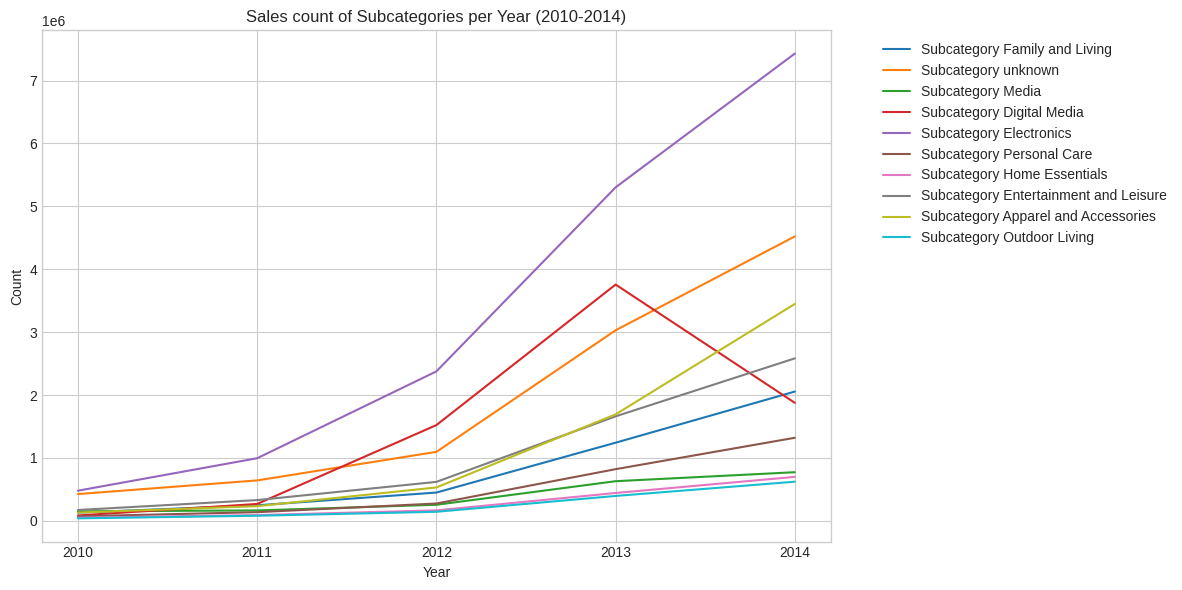

In [82]:
plt = plot_all_sub(df_pd)
#plt.savefig('1.png')

### Plot single sub-category trend

In [83]:
def plot_category(category):
    '''
    Method to plot single category
    Takes in one string parameter: category
    '''
    plt.figure(figsize = (12, 6))
    df = df_pd[df_pd['subcategory'] == category]
    
    df_grouped = df.groupby('year')['count'].sum().reset_index()
    df_grouped = df_grouped.sort_values(by='year')
    plt.figure(figsize=(12, 6))
    plt.plot(df_grouped['year'], df_grouped['count'], label = 'Subcategory Media')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Sales count of %s Subcategory per Year' % category)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.xticks(np.arange(2010, 2015, 1))
    plt.tight_layout()
    return plt

In [84]:
subcategory_list = list(set(subcategory_mapping.values()))
subcategory_list

['Outdoor Living',
 'Media',
 'Family and Living',
 'Digital Media',
 'Entertainment and Leisure',
 'Electronics',
 'Personal Care',
 'Apparel and Accessories',
 'Home Essentials']

<Figure size 1200x600 with 0 Axes>

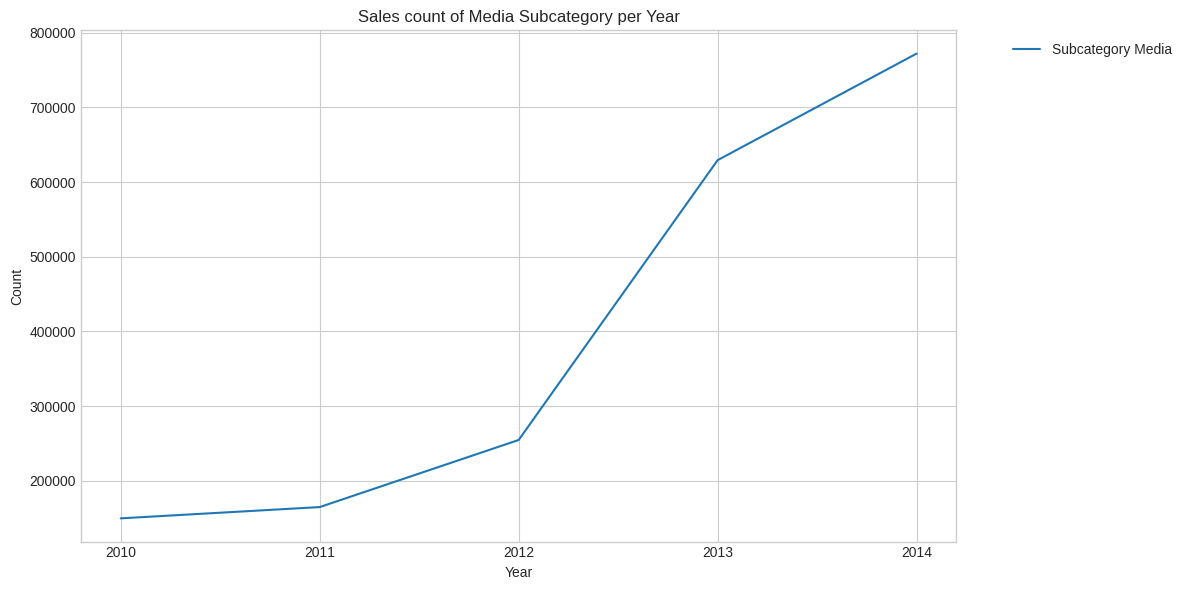

In [85]:
##################### SET CATEGORY ###########################
subcategory = 'Media'

plt = plot_category(subcategory)
#plt.savefig('2.png')

### Plot category trends in one sub-category

In [86]:
count_per_month_ = train_df.groupBy("year", "month", "subcategory", "product_category").agg(F.count("*").alias("count"))
df_pd_ = count_per_month_.toPandas()
df_pd_.head()

,year,month,subcategory,product_category,count
0,2014,12,Family and Living,Automotive,137851
1,2014,11,Family and Living,Automotive,108319
2,2014,10,Family and Living,Automotive,104014
3,2014,9,Family and Living,Automotive,101488
4,2014,8,Family and Living,Automotive,108145


In [87]:
def plot_categories(subcategory):
    '''
    Plots category trends in one category
    Takes in one string parameter: subcategory
    '''
    df_subcat = df_pd_[df_pd_['subcategory'] == subcategory]
    
    plt.figure(figsize = (12, 6))
    
    for product_category in df_subcat['product_category'].unique():
        df_product_cat = df_subcat[df_subcat['product_category'] == product_category]
        df_product_cat = df_product_cat.sort_values(by='year')
        df_product_cat = df_product_cat.groupby('year')['count'].sum().reset_index()
        plt.plot(df_product_cat['year'], df_product_cat['count'], label=f'Category {product_category}')
        
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Sales Count of %s Categories per Year (2010-2014)' % subcategory)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(np.arange(2010, 2015, 1))
    plt.tight_layout()
    return plt

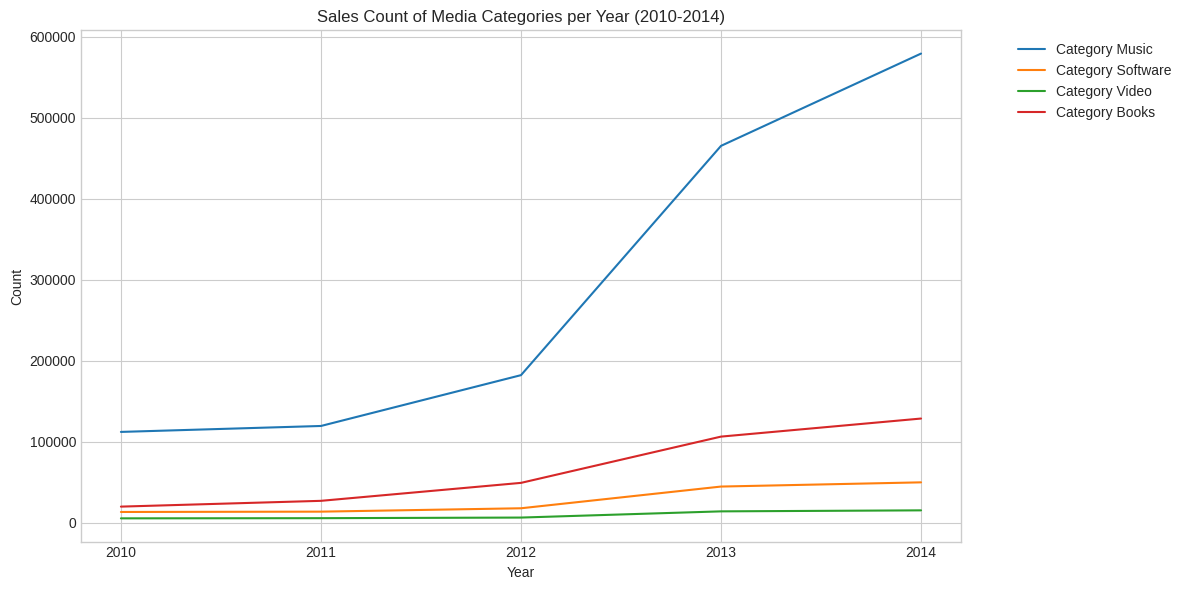

In [88]:
##################### SET SUBCATEGORY ###########################
subcategory = 'Media'

plt = plot_categories(subcategory)
#plt.savefig('3.png')

### Plot Seasonal Decomposition

In [89]:
def seasonal_decomp(df):
    count_per_month2 = df.groupBy("review_date", "subcategory").agg(F.count("*").alias("count"))
    df_pd2 = count_per_month2.toPandas()
    
    df_pd2 = df_pd2[df_pd2['subcategory'] == 'Media']
    df_pd2.set_index('review_date', inplace=True)
    count_series = df_pd2['count']
    
    result = seasonal_decompose(count_series, model='additive', period=30)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed, label='Original', color='blue')
    plt.legend(loc='upper left')
    plt.xticks(rotation=90)
    plt.subplot(412)
    plt.plot(result.trend, label='Trend', color='blue')
    plt.legend(loc='upper left')
    plt.xticks(rotation=90)
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonality', color='blue')
    plt.legend(loc='upper left')
    plt.xticks(rotation=90)
    plt.subplot(414)
    plt.plot(result.resid, label='Residuals', color='blue')
    plt.legend(loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt

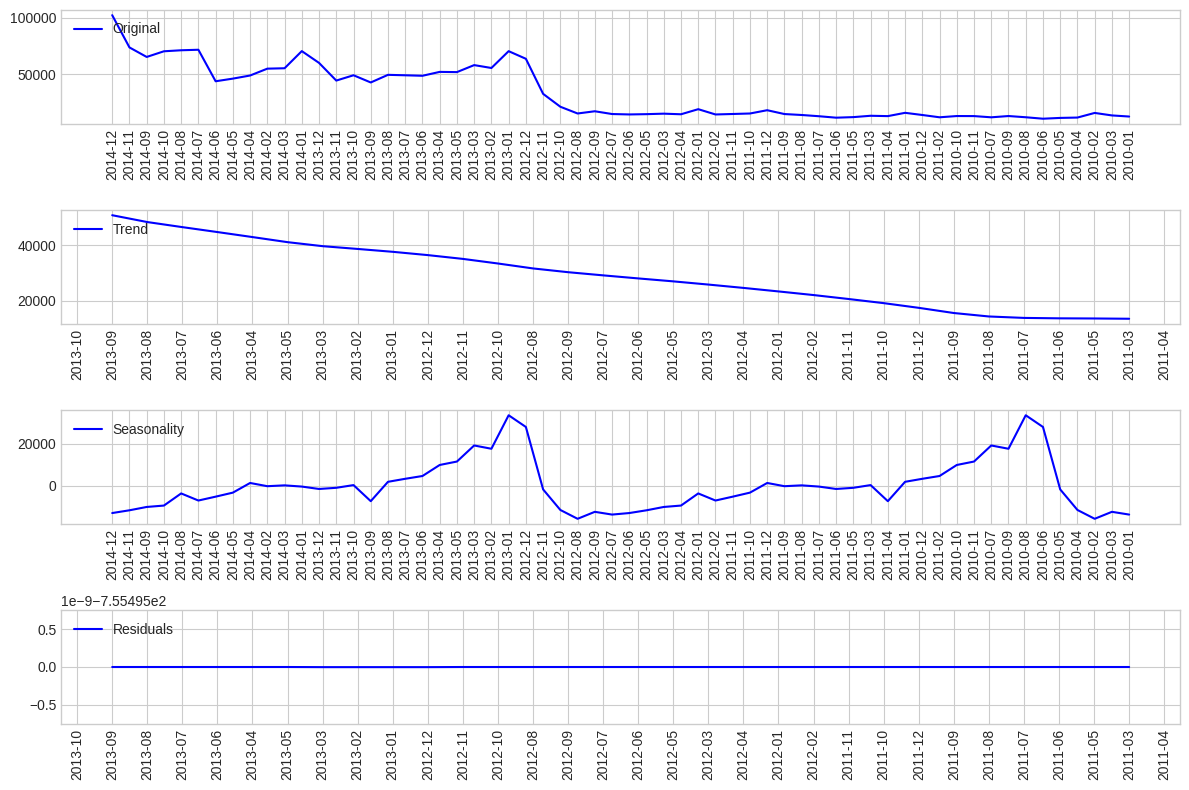

In [90]:
plt = seasonal_decomp(train_df)
#plt.savefig('4.png')

# Model 1
* Train your first model
## Tune ARIMA Model Parameters

In [91]:
##################### SET SUBCATEGORY ###########################
subcategory = 'Media'

<Figure size 1200x600 with 0 Axes>

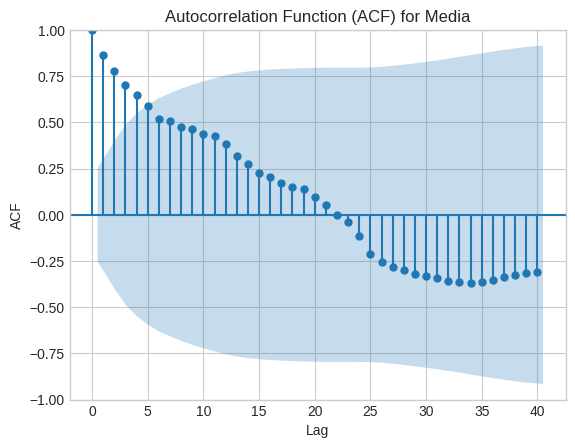

<Figure size 1200x600 with 0 Axes>

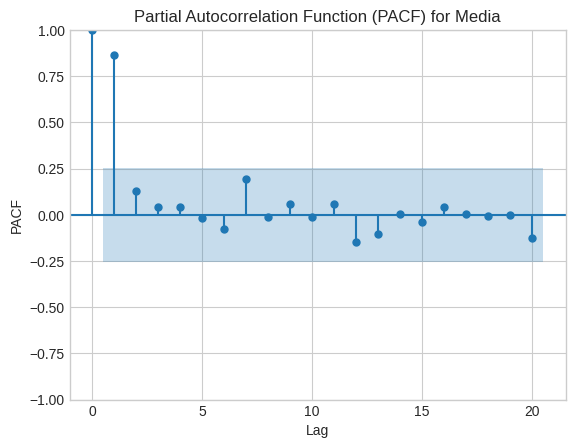

Forecast: 60    102013.470933
61     99242.065756
62     98017.666412
63     95631.011578
64     97828.207654
65     96943.917359
66     97299.811552
67     97156.577280
Name: predicted_mean, dtype: float64


In [92]:
df_subcat = df_pd[df_pd['subcategory'] == subcategory]
df_subcat['date'] = pd.to_datetime(df_subcat[['year', 'month']].assign(day = 1))
df_subcat.sort_values(by = 'date', inplace = True)
    
series = df_subcat.set_index('date')['count']

# ACF plot
plt.figure(figsize = (12, 6))
plot_acf(series, lags = 40, alpha = 0.05)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF) for %s' %subcategory)
plt.grid(True)
plt.show()
    
# PACF plot
plt.figure(figsize = (12, 6))
plot_pacf(series, lags = 20, alpha = 0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF) for %s' %subcategory)
plt.grid(True)
plt.show()
    
# Extract the time series data
series = df_subcat['count']
    
# Fit ARIMA model p,d,q
model = ARIMA(series, order=(1, 1, 5))  
model_fit = model.fit()
    
# 2015 Predictions 
forecast_steps = 8
forecast = model_fit.forecast(steps = forecast_steps) 
print("Forecast:", forecast)

In [93]:
def ACF():
    # ACF plot
    plt.figure(figsize = (12, 6))
    plot_acf(series, lags = 40, alpha = 0.05)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('Autocorrelation Function (ACF) for %s' %subcategory)
    plt.grid(True)
    plt.tight_layout()
    return plt

<Figure size 1200x600 with 0 Axes>

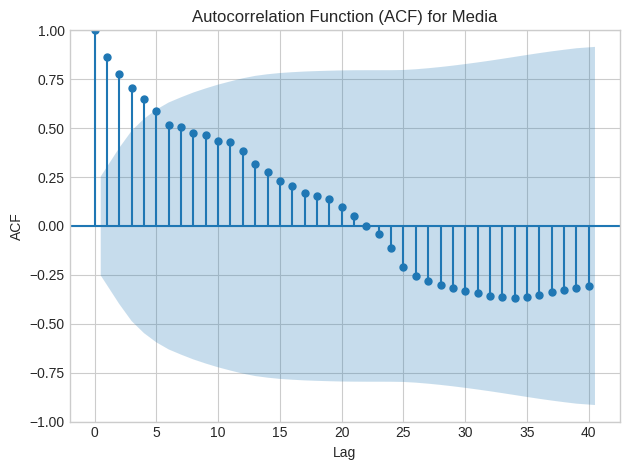

In [94]:
plt = ACF()
#plt.savefig('5.png')

In [95]:
def PACF():
    # PACF plot
    plt.figure(figsize = (12, 6))
    plot_pacf(series, lags = 20, alpha = 0.05)
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('Partial Autocorrelation Function (PACF) for %s' %subcategory)
    plt.grid(True)
    plt.tight_layout()
    return plt

<Figure size 1200x600 with 0 Axes>

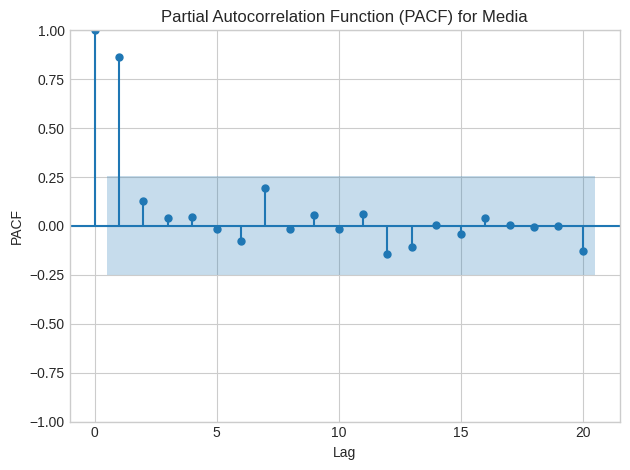

In [96]:
plt = PACF()
#plt.savefig('6.png')

## Time series model

In [97]:
def time_series():
    # time series data plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_subcat['date'], df_subcat['count'], label='Actual')
    
    # Plot the forecast
    forecast_dates = pd.date_range(start=df_subcat['date'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
    plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title('Time Series Data and ARIMA Forecast for %s Year 2014' % subcategory)
    plt.legend()
    
    plt.grid(True)
    plt.tight_layout()
    return plt

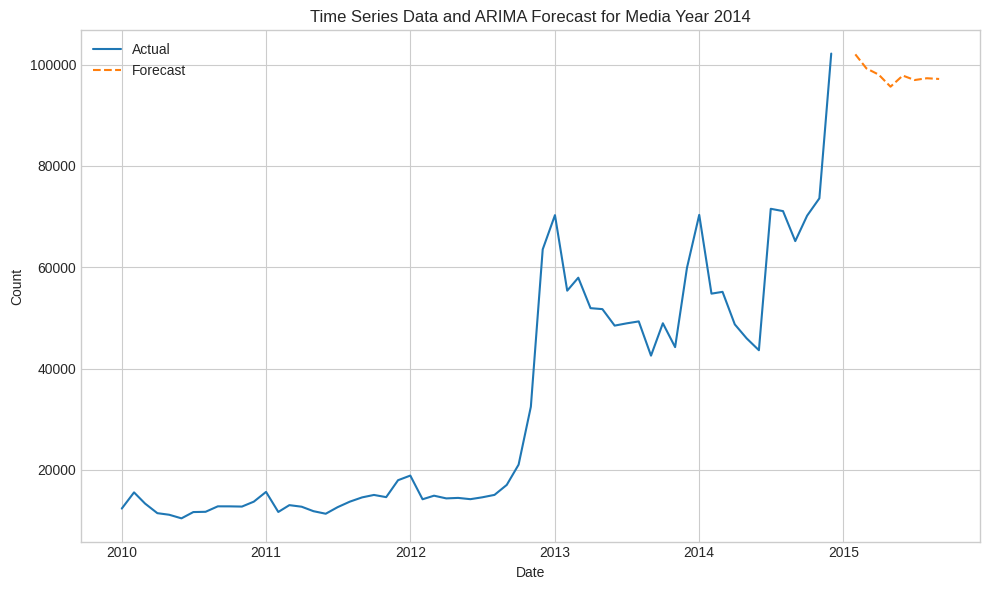

In [98]:
plt = time_series()
#plt.savefig('7.png')

# Data Evaluation
* Evaluate your model and compare training vs. test error

In [99]:
from pyspark.sql.functions import col, date_format, year, month
test_df_filter = test.filter(col('product_category').isin('Video DVD', 'Music', 'Books', 'Video Games'))
test_df_filter= test_df_filter.select(col('review_date'), col('product_category'))
test_df_filter = test_df_filter.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
test_df_filter = test_df_filter.withColumn("year", year("review_date"))
test_df_filter = test_df_filter.withColumn("month", month("review_date"))
#test_df_1 = test_df.filter((col('product_category') == 32))
test_df_filter.show(3)

+-----------+----------------+----+-----+
|review_date|product_category|year|month|
+-----------+----------------+----+-----+
|    2015-08|           Music|2015|    8|
|    2015-08|           Music|2015|    8|
|    2015-08|           Music|2015|    8|
+-----------+----------------+----+-----+
only showing top 3 rows



In [100]:
from pyspark.sql.functions import year, month, count as spark_count
# Group by 'year', 'month', and 'product_category_num' and count occurrences
test_count_per_month = test_df_filter.groupBy("year", "month").agg(spark_count("*").alias("count"))

test_count_per_month.show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2015|    8|195402|
|2015|    7|198553|
|2015|    6|194795|
|2015|    5|202111|
|2015|    4|219000|
|2015|    3|265496|
|2015|    2|263192|
|2015|    1|302662|
+----+-----+------+



In [101]:
test_count_per_month_pd = test_count_per_month.toPandas()
test_count_per_month_pd['date'] = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
test_count_per_month_pd.sort_values(by='date', inplace=True)

In [102]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_values = test_count_per_month.select('count').rdd.flatMap(lambda x: x).collect()
rmse = sqrt(mean_squared_error(test_values, forecast))
print('Test RMSE:', rmse)
# this is how off we predicted the actualy values. 

Test RMSE: 137900.790439641


In [103]:
def plot_forecast_train_test(subcategory):
    # Plot forecast, training, and testing data
    df_media = df_pd[df_pd['subcategory'] == subcategory]
    
    df_media['date'] = pd.to_datetime(df_media[['year', 'month']].assign(day=1))
    df_media.sort_values(by='date', inplace=True)
    
    plt.plot(df_media['date'], model_fit.fittedvalues, color='green', label='Training Forecast')
    
    
    test_dates = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
    plt.plot(test_dates, test_values, label='Testing Data')
    
    # Plot forecast
    plt.plot(test_dates, forecast, color='red', label='Forecast')
    
    plt.title('ARIMA Forecast for 2015 %s' % subcategory)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45) 
    plt.legend()
    plt.tight_layout()
    return plt

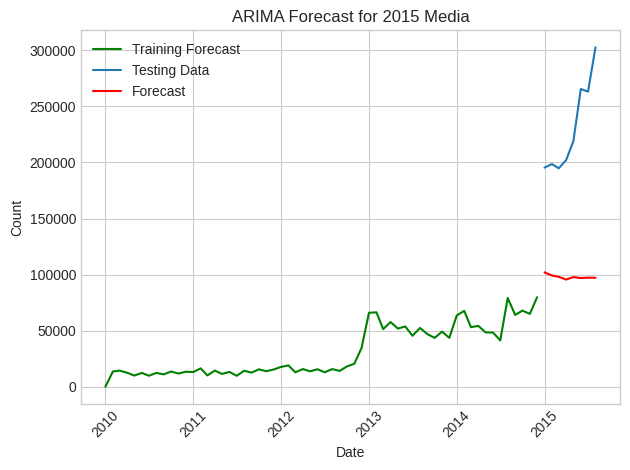

In [104]:
subcategory = 'Media'
plt = plot_forecast_train_test(subcategory)
#plt.savefig('8.png')

### Fitting Graph

In [ ]:
import warnings
warnings.filterwarnings("ignore")

count_per_month2 = count_per_month.filter((col('subcategory') == subcategory))
train_values = count_per_month2.select('count').rdd.flatMap(lambda x: x).collect()

test_errors = []
train_errors = []
i_values = list(range(1,5))

for i in i_values:
    model = ARIMA(series, order=(5, 1+i, 5+i))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)
    train_rmse = sqrt(mean_squared_error(train_values, model_fit.fittedvalues))
    train_errors.append(train_rmse)
    
    test_rmse = sqrt(mean_squared_error(test_values, forecast))
    test_errors.append(test_rmse)

In [ ]:
def plot_train_test():
    plt.figure(figsize=(10, 6))
    plt.plot(i_values, train_errors, label='Train RMSE', marker='o')
    plt.plot(i_values, test_errors, label='Test RMSE', marker='o')
    plt.xlabel('i')
    plt.ylabel('RMSE')
    plt.title('ARIMA Model: Train and Test RMSE vs. i for %s' % subcategory)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return plt

In [ ]:
plt = plot_train_test()
#plt.savefig('9.png')

In [ ]:
def plot_train():
    plt.figure(figsize=(10, 6))
    plt.plot(i_values, train_errors, label='Train RMSE', marker='o')
    # plt.plot(i_values, test_errors, label='Test RMSE', marker='o')
    plt.xlabel('i')
    plt.ylabel('RMSE')
    plt.title('ARIMA Model: Train RMSE vs. i for %s' % subcategory)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return plt

In [ ]:
plt = plot_train()
#plt.savefig('10.png')

In [ ]:
train_errors

# Answer the questions
* Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?

Based on the ARIMA model for product_category_num 32 of the year 2014, we forcasted the estimate of sales (with assumption based on reviews). The next models will include more training data, prior to 2014 for all product catgeories. We may possibily utilize the word2vector data to see the primary key words that have the highest count of reviews which we assume correlates to high counts of purchases. Through this we can forcast what speciifc item or product_category_num will increase in sales. However before moving on to more complicated models, our team will focus on building upon the ARIMA model to more acurately forcast which product_category_num is rise in sales/popular as the forcasted and test data concluded with a RMSE of 28498.15662477966. 

# Conclusion section
* What is the conclusion of your 1st model? What can be done to possibly improve it?

The 1st model concluded with an RMSE of 28498.156. This isn't the best given that there is almost a difference of 30k of the forcsted and the actualy 2015 test data for the product_category_num 32. We can increase the training data from 2014 to the range of 2010 to 2014. We do this for all the product_category_num to be able to accurately predict which item is more popular.  By increasing the training data we will be able to catch more underlying patterns thorughout the years. 